In [ ]:
pip install pandas scikit-learn spacy nltk

In [ ]:
!pip install ipywidgets

In [ ]:
pip install dataframe-image

In [ ]:
pip install termcolor

In [ ]:
# For spacy, we need to download language models for French and Spanish
!python -m spacy download fr_core_news_sm
!python -m spacy download es_core_news_sm

In [2]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.stem import WordNetLemmatizer
import spacy
from tqdm.auto import tqdm
import torch
from torch.utils.data import DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

### Data Preparation for Cross-Model Evaluation

In the context of cross-model evaluation, where the goal is to train and test models on different datasets, special attention must be given to the issue of data leakage. This is particularly important when dealing with datasets that contain overlapping human-written texts across different sources.

#### Problem Statement
Each dataset (`English_(open-mistral-7b)`, `English_(gemini-pro)`, and `English_(gpt-3.5-turbo-0125)`) includes texts generated by humans that are identical across datasets. This overlap can lead to biased model evaluations if not properly handled, as models might appear more accurate simply because they have "seen" the test texts during training.

#### Solution Approach
To prevent data leakage:
1. **Dataset Splitting**: The `split_and_prepare_datasets_cross_model` function initially splits the primary training dataset (`df_train`) into training, validation, and test subsets, adhering to the ratios of 70%, 10%, and 20% respectively. This ensures that each subset serves its purpose without overlap.
2. **Tracking Overlapping Texts**: It then extracts titles from human-written texts in the training set to identify and exclude these from the testing datasets (`df_test_1` and `df_test_2`), which corresponds to other model datasets in this case.
3. **Ensuring Fair Test Sets**: Post exclusion, the remaining human texts in the test datasets are likely fewer than AI-generated texts. To balance this, the function adjusts the number of AI texts to match the available human texts, thus maintaining an equal chance of selecting between AI and human-written texts during model testing.
4. **Final Dataset Preparation**: The balanced AI and remaining human texts are combined to form the final test sets for external evaluation.

This approach not only ensures fair model evaluations by preventing data leakage but also maintains the integrity of the test results across different AI models.



In [3]:
# Load Spacy models for French and Spanish
nlp_fr = spacy.load('fr_core_news_sm')
nlp_es = spacy.load('es_core_news_sm')

# Ensure NLTK resources are downloaded (needed for lemmatization)
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

#---------------------------------------------------------------------

def preprocess_text(text, lower=True, remove_punctuation=True, lemmatize=True, language='en'):
    if lower:
        text = text.lower()
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    if lemmatize:
        if language == 'en':
            lemmatizer = WordNetLemmatizer()
            word_list = nltk.word_tokenize(text)
            text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
        elif language == 'fr':
            doc = nlp_fr(text)
            text = ' '.join([token.lemma_ for token in doc])
        elif language == 'es':
            doc = nlp_es(text)
            text = ' '.join([token.lemma_ for token in doc])
    return text

#---------------------------------------------------------------------

def apply_preprocessing(df, text_column='text', language='en'):
    df[text_column] = df[text_column].apply(lambda x: preprocess_text(x, language=language))
    return df

#---------------------------------------------------------------------

# Function to split the datasets and ensure no overlap in 'Human' texts
def split_and_prepare_datasets_cross_model(df_train, df_test_1, df_test_2):
    # Split the training dataset into train, validation, and test sets
    train_ratio = 0.70
    validation_ratio = 0.10
    test_ratio = 0.20
    # Calculate the test and validation sizes based on the remaining dataset after initial training split
    test_size = test_ratio / (test_ratio + validation_ratio)

    # First split to separate out the training data
    df_train_split, df_temp = train_test_split(df_train, test_size=(1 - train_ratio), stratify=df_train['write_by'], random_state=42)

    # Second split to separate out the validation and test data
    df_val_split, df_test_split = train_test_split(df_temp, test_size=test_size, stratify=df_temp['write_by'], random_state=42)

    # Get the 'Human' text titles from the training part
    human_titles_in_train = df_train_split[df_train_split['write_by'] == 'Human']['title'].tolist()

    # Prepare test datasets
    df_test_1_human = df_test_1[df_test_1['write_by'] == 'Human']
    df_test_1_ai = df_test_1[df_test_1['write_by'] == 'Ai']

    df_test_2_human = df_test_2[df_test_2['write_by'] == 'Human']
    df_test_2_ai = df_test_2[df_test_2['write_by'] == 'Ai']

    # Filter out the 'Human' texts in the test datasets that are in the training titles
    df_test_1_human_filtered = df_test_1_human[~df_test_1_human['title'].isin(human_titles_in_train)]
    df_test_2_human_filtered = df_test_2_human[~df_test_2_human['title'].isin(human_titles_in_train)]

    # Re-balance the 'Ai' texts to match the number of 'Human' texts
    n_human_texts_test_1 = df_test_1_human_filtered.shape[0]
    df_test_1_ai_balanced = df_test_1_ai.sample(n_human_texts_test_1, random_state=42)

    n_human_texts_test_2 = df_test_2_human_filtered.shape[0]
    df_test_2_ai_balanced = df_test_2_ai.sample(n_human_texts_test_2, random_state=42)

    # Combine the balanced 'Ai' texts with 'Human' texts
    df_test_1_final = pd.concat([df_test_1_ai_balanced, df_test_1_human_filtered])
    df_test_2_final = pd.concat([df_test_2_ai_balanced, df_test_2_human_filtered])

    return df_train_split, df_val_split, df_test_split, df_test_1_final, df_test_2_final


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\amirm\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amirm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amirm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# %%time

# Define paths
path_colab = '/content/drive/MyDrive/Colab Notebooks/3_Final_Dataset/'
path_notebook = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/3_Final_Dataset/'

# Toggle this to switch between Colab and local notebook paths
use_colab = False

# Set the base path based on the flag
base_path = path_colab if use_colab else path_notebook

#---------------------------------------------------------------------

# Helper function to read datasets
def load_dataset(file_name):
    return pd.read_csv(base_path + file_name)
#---------------------------------------------------------------------

# Helper function to preprocess datasets
def preprocess_dataset(df, language):
    return apply_preprocessing(df, language=language)

#---------------------------------------------------------------------

# English datasets
df_en_mistral = load_dataset('English_(open-mistral-7b).csv')
df_en_gemini = load_dataset('English_(gemini-pro).csv')
df_en_gpt = load_dataset('English_(gpt-3.5-turbo-0125).csv')

#---------------------------------------------------------------------

# French datasets
df_fr_mistral = load_dataset('French_(open-mistral-7b).csv')
df_fr_gemini = load_dataset('French_(gemini-pro).csv')
df_fr_gpt = load_dataset('French_(gpt-3.5-turbo-0125).csv')

#---------------------------------------------------------------------

# Spanish datasets
df_es_mistral = load_dataset('Spanish_(open-mistral-7b).csv')
df_es_gemini = load_dataset('Spanish_(gemini-pro).csv')
df_es_gpt = load_dataset('Spanish_(gpt-3.5-turbo-0125).csv')


In [ ]:
# # Preprocess English datasets
# df_en_mistral_preprocessed = preprocess_dataset(df_en_mistral, 'en')
# df_en_gemini_preprocessed = preprocess_dataset(df_en_gemini, 'en')
# df_en_gpt_preprocessed = preprocess_dataset(df_en_gpt, 'en')

# #---------------------------------------------------------------------

# # Preprocess French datasets
# df_fr_mistral_preprocessed = preprocess_dataset(df_fr_mistral, 'fr')
# df_fr_gemini_preprocessed = preprocess_dataset(df_fr_gemini, 'fr')
# df_fr_gpt_preprocessed = preprocess_dataset(df_fr_gpt, 'fr')

# #---------------------------------------------------------------------

# # Preprocess Spanish datasets
# df_es_mistral_preprocessed = preprocess_dataset(df_es_mistral, 'es')
# df_es_gemini_preprocessed = preprocess_dataset(df_es_gemini, 'es')
# df_es_gpt_preprocessed = preprocess_dataset(df_es_gpt, 'es')

In [5]:
# Call the function to split the datasets for English
df_en_mistral_train, df_en_mistral_val, df_en_mistral_internaltest, df_en_gemini_externaltest_for_mistral_model, df_en_gpt_externaltest_for_mistral_model = split_and_prepare_datasets_cross_model(
    df_en_mistral, df_en_gemini, df_en_gpt)

df_en_gemini_train, df_en_gemini_val, df_en_gemini_internaltest, df_en_mistral_externaltest_for_gemini_model, df_en_gpt_externaltest_for_gemini_model = split_and_prepare_datasets_cross_model(
    df_en_gemini, df_en_mistral, df_en_gpt)

df_en_gpt_train, df_en_gpt_val, df_en_gpt_internaltest, df_en_gemini_externaltest_for_gpt_model, df_en_mistral_externaltest_for_gpt_model = split_and_prepare_datasets_cross_model(
    df_en_gpt, df_en_gemini, df_en_mistral)

# ---------------------------------------------------------------------

# Call the function to split the datasets for French
df_fr_mistral_train, df_fr_mistral_val, df_fr_mistral_internaltest, df_fr_gemini_externaltest_for_mistral_model, df_fr_gpt_externaltest_for_mistral_model = split_and_prepare_datasets_cross_model(
    df_fr_mistral, df_fr_gemini, df_fr_gpt
)

df_fr_gemini_train, df_fr_gemini_val, df_fr_gemini_internaltest, df_fr_mistral_externaltest_for_gemini_model, df_fr_gpt_externaltest_for_gemini_model = split_and_prepare_datasets_cross_model(
    df_fr_gemini, df_fr_mistral, df_fr_gpt
)

df_fr_gpt_train, df_fr_gpt_val, df_fr_gpt_internaltest, df_fr_gemini_externaltest_for_gpt_model, df_fr_mistral_externaltest_for_gpt_model = split_and_prepare_datasets_cross_model(
    df_fr_gpt, df_fr_gemini, df_fr_mistral
)

# ---------------------------------------------------------------------

# Call the function to split the datasets for Spanish
df_es_mistral_train, df_es_mistral_val, df_es_mistral_internaltest, df_es_gemini_externaltest_for_mistral_model, df_es_gpt_externaltest_for_mistral_model = split_and_prepare_datasets_cross_model(
    df_es_mistral, df_es_gemini, df_es_gpt
)

df_es_gemini_train, df_es_gemini_val, df_es_gemini_internaltest, df_es_mistral_externaltest_for_gemini_model, df_es_gpt_externaltest_for_gemini_model = split_and_prepare_datasets_cross_model(
    df_es_gemini, df_es_mistral, df_es_gpt
)

df_es_gpt_train, df_es_gpt_val, df_es_gpt_internaltest, df_es_gemini_externaltest_for_gpt_model, df_es_mistral_externaltest_for_gpt_model = split_and_prepare_datasets_cross_model(
    df_es_gpt, df_es_gemini, df_es_mistral
)


In [ ]:
# # Call the function to split the datasets for English preprocessed (lower, remove_punctuation, lemmatize)
# df_en_mistral_train_pre, df_en_mistral_val_pre, df_en_mistral_internaltest_pre, df_en_gemini_externaltest_for_mistral_model_pre, df_en_gpt_externaltest_for_mistral_model_pre = split_and_prepare_datasets_cross_model(
#     df_en_mistral_preprocessed, df_en_gemini_preprocessed, df_en_gpt_preprocessed
# )

# df_en_gemini_train_pre, df_en_gemini_val_pre, df_en_gemini_internaltest_pre, df_en_mistral_externaltest_for_gemini_model_pre, df_en_gpt_externaltest_for_gemini_model_pre = split_and_prepare_datasets_cross_model(
#     df_en_gemini_preprocessed, df_en_mistral_preprocessed, df_en_gpt_preprocessed
# )

# df_en_gpt_train_pre, df_en_gpt_val_pre, df_en_gpt_internaltest_pre, df_en_gemini_externaltest_for_gpt_model_pre, df_en_mistral_externaltest_for_gpt_model_pre = split_and_prepare_datasets_cross_model(
#     df_en_gpt_preprocessed, df_en_gemini_preprocessed, df_en_mistral_preprocessed
# )

# # ---------------------------------------------------------------------

# # Call the function to split the datasets for French preprocessed (lower, remove_punctuation, lemmatize)
# df_fr_mistral_train_pre, df_fr_mistral_val_pre, df_fr_mistral_internaltest_pre, df_fr_gemini_externaltest_for_mistral_model_pre, df_fr_gpt_externaltest_for_mistral_model_pre = split_and_prepare_datasets_cross_model(
#     df_fr_mistral_preprocessed, df_fr_gemini_preprocessed, df_fr_gpt_preprocessed
# )

# df_fr_gemini_train_pre, df_fr_gemini_val_pre, df_fr_gemini_internaltest_pre, df_fr_mistral_externaltest_for_gemini_model_pre, df_fr_gpt_externaltest_for_gemini_model_pre = split_and_prepare_datasets_cross_model(
#     df_fr_gemini_preprocessed, df_fr_mistral_preprocessed, df_fr_gpt_preprocessed
# )

# df_fr_gpt_train_pre, df_fr_gpt_val_pre, df_fr_gpt_internaltest_pre, df_fr_gemini_externaltest_for_gpt_model_pre, df_fr_mistral_externaltest_for_gpt_model_pre = split_and_prepare_datasets_cross_model(
#     df_fr_gpt_preprocessed, df_fr_gemini_preprocessed, df_fr_mistral_preprocessed
# )

# # ---------------------------------------------------------------------

# # Call the function to split the datasets for Spanish preprocessed (lower, remove_punctuation, lemmatize)
# df_es_mistral_train_pre, df_es_mistral_val_pre, df_es_mistral_internaltest_pre, df_es_gemini_externaltest_for_mistral_model_pre, df_es_gpt_externaltest_for_mistral_model_pre = split_and_prepare_datasets_cross_model(
#     df_es_mistral_preprocessed, df_es_gemini_preprocessed, df_es_gpt_preprocessed
# )

# df_es_gemini_train_pre, df_es_gemini_val_pre, df_es_gemini_internaltest_pre, df_es_mistral_externaltest_for_gemini_model_pre, df_es_gpt_externaltest_for_gemini_model_pre = split_and_prepare_datasets_cross_model(
#     df_es_gemini_preprocessed, df_es_mistral_preprocessed, df_es_gpt_preprocessed
# )

# df_es_gpt_train_pre, df_es_gpt_val_pre, df_es_gpt_internaltest_pre, df_es_gemini_externaltest_for_gpt_model_pre, df_es_mistral_externaltest_for_gpt_model_pre = split_and_prepare_datasets_cross_model(
#     df_es_gpt_preprocessed, df_es_gemini_preprocessed, df_es_mistral_preprocessed
# )


**Verification Steps**

1. **Check for Title Overlap**:
   - Ensure that none of the titles from human-written texts in the training dataset appear in either of the test datasets.

2. **Inspect Data Counts**:
   - Verify that the count of AI and human texts remains balanced in the test sets after filtering and rebalancing.

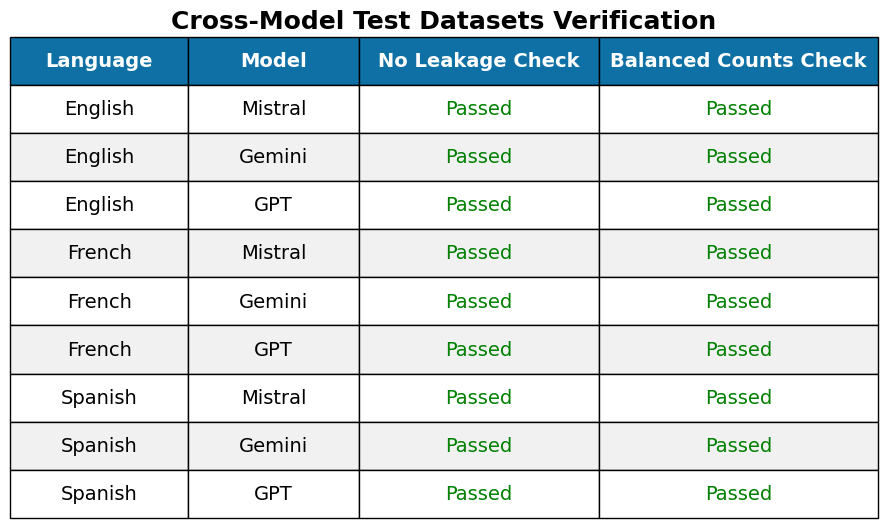

In [22]:
# Define the functions to verify leakage and balanced counts
def verify_no_leakage(train_set, test_sets, column='title'):
    train_titles = set(train_set[train_set['write_by'] == 'Human'][column])
    test_titles = [set(test_set[test_set['write_by'] == 'Human'][column]) for test_set in test_sets]
    overlaps = [train_titles.intersection(test) for test in test_titles]
    no_leakage = all(len(overlap) == 0 for overlap in overlaps)
    return no_leakage, overlaps

def verify_balanced_counts(test_sets):
    human_counts = [test_set[test_set['write_by'] == 'Human'].shape[0] for test_set in test_sets]
    ai_counts = [test_set[test_set['write_by'] == 'Ai'].shape[0] for test_set in test_sets]
    balanced = [human_count == ai_count for human_count, ai_count in zip(human_counts, ai_counts)]
    return all(balanced), list(zip(human_counts, ai_counts))

# Collect results into a DataFrame
results = []

datasets = {
    'English': {
        'Mistral': (df_en_mistral_train, [df_en_gemini_externaltest_for_mistral_model, df_en_gpt_externaltest_for_mistral_model]),
        'Gemini': (df_en_gemini_train, [df_en_mistral_externaltest_for_gemini_model, df_en_gpt_externaltest_for_gemini_model]),
        'GPT': (df_en_gpt_train, [df_en_gemini_externaltest_for_gpt_model, df_en_mistral_externaltest_for_gpt_model])
    },
    'French': {
        'Mistral': (df_fr_mistral_train, [df_fr_gemini_externaltest_for_mistral_model, df_fr_gpt_externaltest_for_mistral_model]),
        'Gemini': (df_fr_gemini_train, [df_fr_mistral_externaltest_for_gemini_model, df_fr_gpt_externaltest_for_gemini_model]),
        'GPT': (df_fr_gpt_train, [df_fr_gemini_externaltest_for_gpt_model, df_fr_mistral_externaltest_for_gpt_model])
    },
    'Spanish': {
        'Mistral': (df_es_mistral_train, [df_es_gemini_externaltest_for_mistral_model, df_es_gpt_externaltest_for_mistral_model]),
        'Gemini': (df_es_gemini_train, [df_es_mistral_externaltest_for_gemini_model, df_es_gpt_externaltest_for_gemini_model]),
        'GPT': (df_es_gpt_train, [df_es_gemini_externaltest_for_gpt_model, df_es_mistral_externaltest_for_gpt_model])
    }
}

for language, models in datasets.items():
    for model_name, (train_set, test_sets) in models.items():
        leakage_results = verify_no_leakage(train_set, test_sets)
        balanced_counts_results = verify_balanced_counts(test_sets)
        leakage_check, _ = leakage_results
        balanced_check, _ = balanced_counts_results
        results.append({
            'Language': language,
            'Model': model_name,
            'No Leakage Check': 'Passed' if leakage_check else 'Failed',
            'Balanced Counts Check': 'Passed' if balanced_check else 'Failed'
        })

results_df = pd.DataFrame(results)

# Function to render a table in matplotlib
def render_mpl_table(data, row_height=0.625, font_size=14,
                     header_color='#0e70a5', row_colors=['#f1f1f2', 'w'], edge_color='black',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    # Calculate the maximum string length for each column and apply padding
    padding = 15  # Define padding size
    col_widths = [max(data[col].apply(lambda x: len(str(x))).max(), len(
        col)) + padding for col in data.columns]
    col_widths = [x * 0.1 for x in col_widths]  # Scale factor for width

    if ax is None:
        size = (np.array([sum(col_widths), data.shape[0]+1])
                * np.array([1, row_height]))
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,
                         colWidths=col_widths, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        cell.set_text_props(ha='center')
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
            # Set text color based on the cell value
            if cell.get_text().get_text() == 'Passed':
                cell.set_text_props(color='green')
            elif cell.get_text().get_text() == 'Failed':
                cell.set_text_props(color='red')

    return ax

# Render the table and save it as a PNG image
ax = render_mpl_table(results_df, header_columns=0)
plt.title('Cross-Model Test Datasets Verification', fontsize=18, weight='bold')
plt.savefig('cross_model_leakage_and_balanced_counts_check.png', bbox_inches='tight', dpi=300)
plt.show()


In [13]:
# Constants
MODEL_NAME = 'xlm-roberta-base'
MAX_LEN = 512
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)

#---------------------------------------------------------------------

# Dataset Class
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

#---------------------------------------------------------------------

# Function to create data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TextDataset(
        texts=df['text'].to_numpy(),
        labels=df['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(ds, batch_size=batch_size, num_workers=4)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
# Function to train the model
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    total_correct = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        total_correct += torch.sum(preds == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_correct.double() / len(data_loader.dataset), total_loss / len(data_loader.dataset)

#---------------------------------------------------------------------

# Function to evaluate the model with additional metrics
def eval_model(model, data_loader, device):
    model.eval()
    final_labels = []
    final_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=None)  # No labels for prediction mode
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            # Move preds and labels to CPU for metric calculation
            final_labels.extend(labels.cpu().detach().numpy())
            final_preds.extend(preds.cpu().detach().numpy())

    # Calculate metrics
    accuracy = accuracy_score(final_labels, final_preds)
    precision = precision_score(final_labels, final_preds, average='binary')
    recall = recall_score(final_labels, final_preds, average='binary')
    f1 = f1_score(final_labels, final_preds, average='binary')

    return accuracy, precision, recall, f1


In [ ]:
# # Initialize results list
# results = []

# # Train and evaluate function
# def train_and_evaluate(train_data, val_data, internal_test_data, external_test_data_1, external_test_data_2, model_name):
#     # Create data loaders
#     train_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
#     val_loader = create_data_loader(val_data, tokenizer, MAX_LEN, BATCH_SIZE)
#     test_loader = create_data_loader(internal_test_data, tokenizer, MAX_LEN, BATCH_SIZE)
#     external_loader_1 = create_data_loader(external_test_data_1, tokenizer, MAX_LEN, BATCH_SIZE)
#     external_loader_2 = create_data_loader(external_test_data_2, tokenizer, MAX_LEN, BATCH_SIZE)

#     # Initialize model
#     model = XLMRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)
#     optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
#     total_steps = len(train_loader) * EPOCHS
#     scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#     best_val_f1 = 0.0  # Initialize the best F1 score

#     # Train model
#     for epoch in range(EPOCHS):
#         train_acc, train_loss = train_epoch(model, train_loader, optimizer, DEVICE, scheduler)
#         print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss}, Accuracy: {train_acc}')

#         # Evaluate on validation set
#         val_accuracy, val_precision, val_recall, val_f1 = eval_model(model, val_loader, DEVICE)
#         print(f'Validation Metrics - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}')

#         # Check if the current model's F1 score on the validation set is the best one so far
#         if val_f1 > best_val_f1:
#             best_val_f1 = val_f1
#             # Save the model as the best one so far
#             torch.save(model.state_dict(), f"{model_name}.bin")
#             print(f"Saved new best model with F1 score: {val_f1}")

#     # After training all epochs, load the best model for evaluation
#     model.load_state_dict(torch.load(f"{model_name}.bin"))

#     # Evaluate model
#     internal_metrics = eval_model(model, test_loader, DEVICE)
#     external_metrics_1 = eval_model(model, external_loader_1, DEVICE)
#     external_metrics_2 = eval_model(model, external_loader_2, DEVICE)

#     # Append results
#     results.append([model_name, 'Internal Test'] + list(internal_metrics))
#     results.append([model_name, 'External Test 1'] + list(external_metrics_1))
#     results.append([model_name, 'External Test 2'] + list(external_metrics_2))


# # List of dataset groups for training
# dataset_groups = [
#     ('en_mistral', df_en_mistral_train, df_en_mistral_val, df_en_mistral_internaltest, df_en_gemini_externaltest_for_mistral_model, df_en_gpt_externaltest_for_mistral_model),
#     ('en_gemini', df_en_gemini_train, df_en_gemini_val, df_en_gemini_internaltest, df_en_mistral_externaltest_for_gemini_model, df_en_gpt_externaltest_for_gemini_model),
#     ('en_gpt', df_en_gpt_train, df_en_gpt_val, df_en_gpt_internaltest, df_en_gemini_externaltest_for_gpt_model, df_en_mistral_externaltest_for_gpt_model),
#     # Repeat the structure for French datasets
#     ('fr_mistral', df_fr_mistral_train, df_fr_mistral_val, df_fr_mistral_internaltest, df_fr_gemini_externaltest_for_mistral_model, df_fr_gpt_externaltest_for_mistral_model),
#     ('fr_gemini', df_fr_gemini_train, df_fr_gemini_val, df_fr_gemini_internaltest, df_fr_mistral_externaltest_for_gemini_model, df_fr_gpt_externaltest_for_gemini_model),
#     ('fr_gpt', df_fr_gpt_train, df_fr_gpt_val, df_fr_gpt_internaltest, df_fr_gemini_externaltest_for_gpt_model, df_fr_mistral_externaltest_for_gpt_model),
#     # Repeat the structure for Spanish datasets
#     ('es_mistral', df_es_mistral_train, df_es_mistral_val, df_es_mistral_internaltest, df_es_gemini_externaltest_for_mistral_model, df_es_gpt_externaltest_for_mistral_model),
#     ('es_gemini', df_es_gemini_train, df_es_gemini_val, df_es_gemini_internaltest, df_es_mistral_externaltest_for_gemini_model, df_es_gpt_externaltest_for_gemini_model),
#     ('es_gpt', df_es_gpt_train, df_es_gpt_val, df_es_gpt_internaltest, df_es_gemini_externaltest_for_gpt_model, df_es_mistral_externaltest_for_gpt_model),
#     # # Preprocessed English datasets
#     # ('en_mistral_pre', df_en_mistral_train_pre, df_en_mistral_val_pre, df_en_mistral_internaltest_pre, df_en_gemini_externaltest_for_mistral_model_pre, df_en_gpt_externaltest_for_mistral_model_pre),
#     # ('en_gemini_pre', df_en_gemini_train_pre, df_en_gemini_val_pre, df_en_gemini_internaltest_pre, df_en_mistral_externaltest_for_gemini_model_pre, df_en_gpt_externaltest_for_gemini_model_pre),
#     # ('en_gpt_pre', df_en_gpt_train_pre, df_en_gpt_val_pre, df_en_gpt_internaltest_pre, df_en_gemini_externaltest_for_gpt_model_pre, df_en_mistral_externaltest_for_gpt_model_pre),
#     # # Preprocessed French datasets
#     # ('fr_mistral_pre', df_fr_mistral_train_pre, df_fr_mistral_val_pre, df_fr_mistral_internaltest_pre, df_fr_gemini_externaltest_for_mistral_model_pre, df_fr_gpt_externaltest_for_mistral_model_pre),
#     # ('fr_gemini_pre', df_fr_gemini_train_pre, df_fr_gemini_val_pre, df_fr_gemini_internaltest_pre, df_fr_mistral_externaltest_for_gemini_model_pre, df_fr_gpt_externaltest_for_gemini_model_pre),
#     # ('fr_gpt_pre', df_fr_gpt_train_pre, df_fr_gpt_val_pre, df_fr_gpt_internaltest_pre, df_fr_gemini_externaltest_for_gpt_model_pre, df_fr_mistral_externaltest_for_gpt_model_pre),
#     # # Preprocessed Spanish datasets
#     # ('es_mistral_pre', df_es_mistral_train_pre, df_es_mistral_val_pre, df_es_mistral_internaltest_pre, df_es_gemini_externaltest_for_mistral_model_pre, df_es_gpt_externaltest_for_mistral_model_pre),
#     # ('es_gemini_pre', df_es_gemini_train_pre, df_es_gemini_val_pre, df_es_gemini_internaltest_pre, df_es_mistral_externaltest_for_gemini_model_pre, df_es_gpt_externaltest_for_gemini_model_pre),
#     # ('es_gpt_pre', df_es_gpt_train_pre, df_es_gpt_val_pre, df_es_gpt_internaltest_pre, df_es_gemini_externaltest_for_gpt_model_pre, df_es_mistral_externaltest_for_gpt_model_pre),
# ]

# # Loop over the dataset groups and train/evaluate models
# for group in dataset_groups:
#     language_prefix, train_data, val_data, internal_test_data, external_test_data_1, external_test_data_2 = group
#     model_name = f"Cross_Model_{language_prefix}_XLM_RoBERTa"
#     train_and_evaluate(train_data, val_data, internal_test_data, external_test_data_1, external_test_data_2, model_name)



In [ ]:
# Initialize results list
results = []

# Train and evaluate function
def train_and_evaluate(model_name, train_data, val_data, internal_test_data, external_test_data_1, external_test_data_2, internal_test_name, external_test_name_1, external_test_name_2):
    # Create data loaders
    train_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
    val_loader = create_data_loader(val_data, tokenizer, MAX_LEN, BATCH_SIZE)
    test_loader = create_data_loader(internal_test_data, tokenizer, MAX_LEN, BATCH_SIZE)
    external_loader_1 = create_data_loader(external_test_data_1, tokenizer, MAX_LEN, BATCH_SIZE)
    external_loader_2 = create_data_loader(external_test_data_2, tokenizer, MAX_LEN, BATCH_SIZE)

    # Initialize model
    model = XLMRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    best_val_f1 = 0.0  # Initialize the best F1 score

    # Train model
    for epoch in range(EPOCHS):
        train_acc, train_loss = train_epoch(model, train_loader, optimizer, DEVICE, scheduler)
        print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss}, Accuracy: {train_acc}')

        # Evaluate on validation set
        val_accuracy, val_precision, val_recall, val_f1 = eval_model(model, val_loader, DEVICE)
        print(f'Validation Metrics - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}')

        # Check if the current model's F1 score on the validation set is the best one so far
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            # Save the model as the best one so far
            torch.save(model.state_dict(), f"{model_name}.bin")
            print(f"Saved new best model with F1 score: {val_f1}")

    # After training all epochs, load the best model for evaluation
    model.load_state_dict(torch.load(f"{model_name}.bin"))

    # Evaluate model
    internal_metrics = eval_model(model, test_loader, DEVICE)
    external_metrics_1 = eval_model(model, external_loader_1, DEVICE)
    external_metrics_2 = eval_model(model, external_loader_2, DEVICE)

    # Append results with specific test names
    results.append([model_name, internal_test_name] + list(internal_metrics))
    results.append([model_name, external_test_name_1] + list(external_metrics_1))
    results.append([model_name, external_test_name_2] + list(external_metrics_2))


# List of dataset groups for training
dataset_groups = [
    ('en_mistral','en_gemini','en_gpt', df_en_mistral_train, df_en_mistral_val, df_en_mistral_internaltest, df_en_gemini_externaltest_for_mistral_model, df_en_gpt_externaltest_for_mistral_model),
    ('en_gemini', 'en_mistral', 'en_gpt', df_en_gemini_train, df_en_gemini_val, df_en_gemini_internaltest, df_en_mistral_externaltest_for_gemini_model, df_en_gpt_externaltest_for_gemini_model),
    ('en_gpt', 'en_gemini', 'en_mistral', df_en_gpt_train, df_en_gpt_val, df_en_gpt_internaltest, df_en_gemini_externaltest_for_gpt_model, df_en_mistral_externaltest_for_gpt_model),
    # Repeat the structure for French datasets
    ('fr_mistral', 'fr_gemini', 'fr_gpt', df_fr_mistral_train, df_fr_mistral_val, df_fr_mistral_internaltest, df_fr_gemini_externaltest_for_mistral_model, df_fr_gpt_externaltest_for_mistral_model),
    ('fr_gemini', 'fr_mistral', 'fr_gpt', df_fr_gemini_train, df_fr_gemini_val, df_fr_gemini_internaltest, df_fr_mistral_externaltest_for_gemini_model, df_fr_gpt_externaltest_for_gemini_model),
    ('fr_gpt', 'fr_gemini', 'fr_mistral', df_fr_gpt_train, df_fr_gpt_val, df_fr_gpt_internaltest, df_fr_gemini_externaltest_for_gpt_model, df_fr_mistral_externaltest_for_gpt_model),
    # Repeat the structure for Spanish datasets
    ('es_mistral', 'es_gemini', 'es_gpt', df_es_mistral_train, df_es_mistral_val, df_es_mistral_internaltest, df_es_gemini_externaltest_for_mistral_model, df_es_gpt_externaltest_for_mistral_model),
    ('es_gemini', 'es_mistral', 'es_gpt', df_es_gemini_train, df_es_gemini_val, df_es_gemini_internaltest, df_es_mistral_externaltest_for_gemini_model, df_es_gpt_externaltest_for_gemini_model),
    ('es_gpt', 'es_gemini', 'es_mistral', df_es_gpt_train, df_es_gpt_val, df_es_gpt_internaltest, df_es_gemini_externaltest_for_gpt_model, df_es_mistral_externaltest_for_gpt_model),
]

# Loop over the dataset groups and train/evaluate models
for group in dataset_groups:
    internal_test_name, external_test_name_1, external_test_name_2, train_data, val_data, internal_test_data, external_test_data_1, external_test_data_2 = group
    model_name = f"Cross_Model_{internal_test_name}_XLM_RoBERTa"
    train_and_evaluate(model_name, train_data, val_data, internal_test_data, external_test_data_1, external_test_data_2, internal_test_name, external_test_name_1, external_test_name_2)


In [17]:
# Before creating DataFrame, round the metrics in the results list
for i in range(len(results)):
    results[i][2:] = [round(metric, 3) for metric in results[i][2:]]

# Create DataFrame from results with rounded numbers
results_df = pd.DataFrame(results, columns=['Model Train On', 'Test On', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Save the results to a CSV file
results_csv_path = '/content/drive/MyDrive/Colab Notebooks/cross_model_evaluation_results.csv'
results_df.to_csv(results_csv_path, index=False)


In [30]:
results_df = pd.read_csv('cross_model_evaluation_results.csv')

In [31]:
# Function to modify model names
def modify_model_and_test_name(model_name):
    parts = model_name.split('_')
    new_name = ' '.join(parts)
    return new_name

In [32]:
# Function to modify model names
def modify_model_name(model_name):
    parts = model_name.split('_')
    new_name = f"{parts[2]} {parts[3]}"
    return new_name

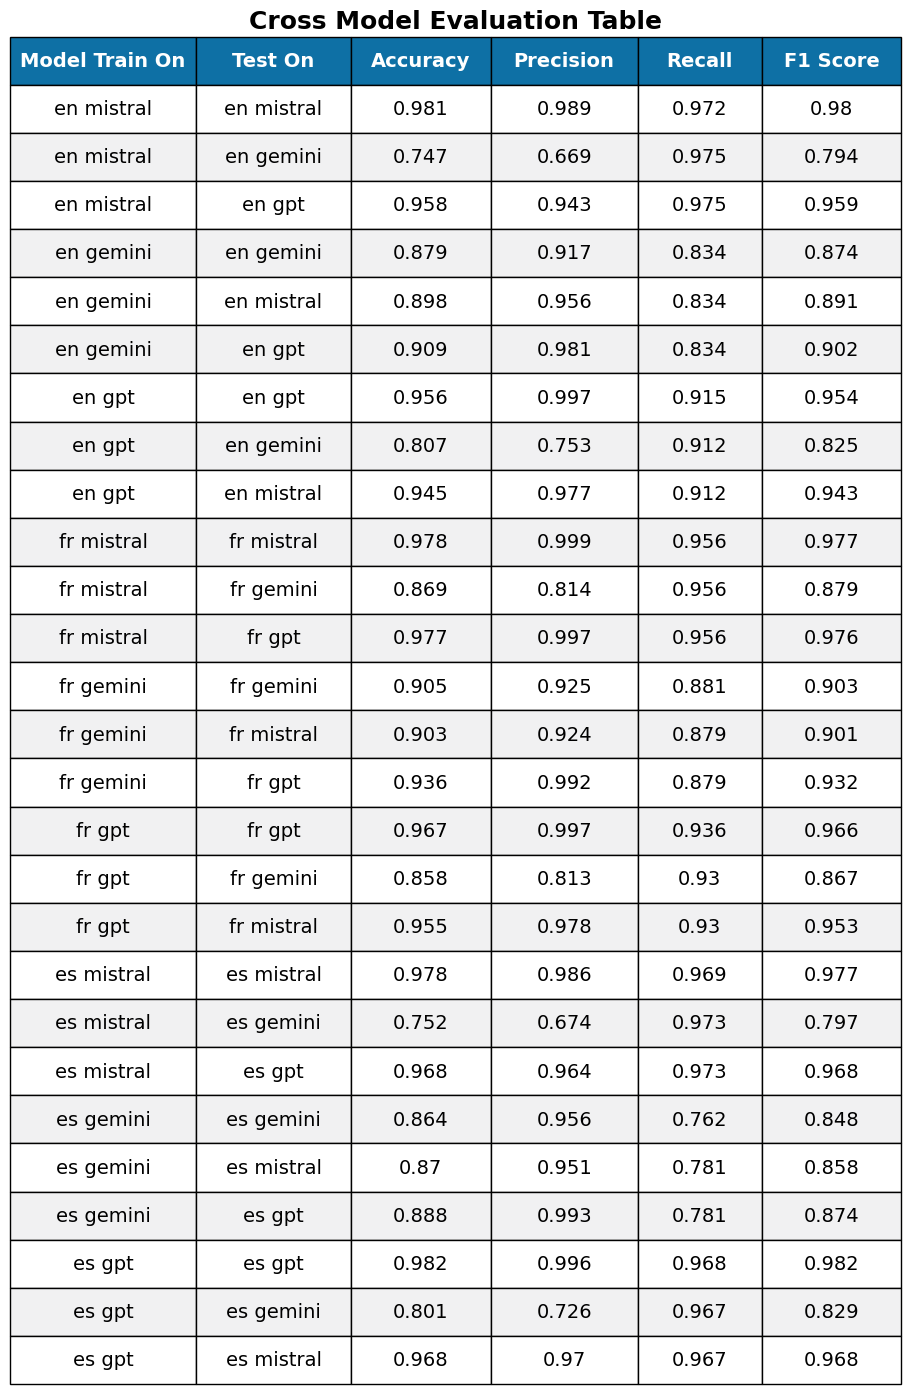

In [33]:
# Function to render a table in matplotlib and adjust column widths based on text length
def render_mpl_table(data, row_height=0.625, font_size=14,
                     header_color='#0e70a5', row_colors=['#f1f1f2', 'w'], edge_color='black',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    data['Model Train On'] = data['Model Train On'].apply(modify_model_name)
    data['Test On'] = data['Test On'].apply(modify_model_and_test_name)

    # Calculate the maximum string length for each column and apply padding
    padding = 10  # Define padding size
    col_widths = [max(data[col].apply(lambda x: len(str(x))).max(), len(
        col)) + padding for col in data.columns]
    col_widths = [x * 0.1 for x in col_widths]  # Scale factor for width

    if ax is None:
        size = (np.array([sum(col_widths), data.shape[0]+1])
                * np.array([1, row_height]))
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,
                         colWidths=col_widths, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)  
        cell.set_text_props(ha='center')  
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    return ax


# Render the table
render_mpl_table(results_df, header_columns=0)
plt.title('Cross Model Evaluation Table', fontsize=18, weight='bold')
plt.savefig('cross_model_evaluation_table.png', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
# To download the models as zip file

import os
import zipfile
from google.colab import files

def zip_files(directory, output_zip):
    # Create a ZipFile object
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through the directory
        for root, dirs, files in os.walk(directory):
            for file in files:
                # Create complete filepath of file in directory
                filepath = os.path.join(root, file)
                # Add file to zip
                zipf.write(filepath, arcname=os.path.relpath(filepath, directory))

# Specify the directory to zip
directory_to_zip = '/content'
output_zip_file = 'content_directory.zip'

# Call the function
zip_files(directory_to_zip, output_zip_file)

# Provide a link to download the zip
files.download(output_zip_file)


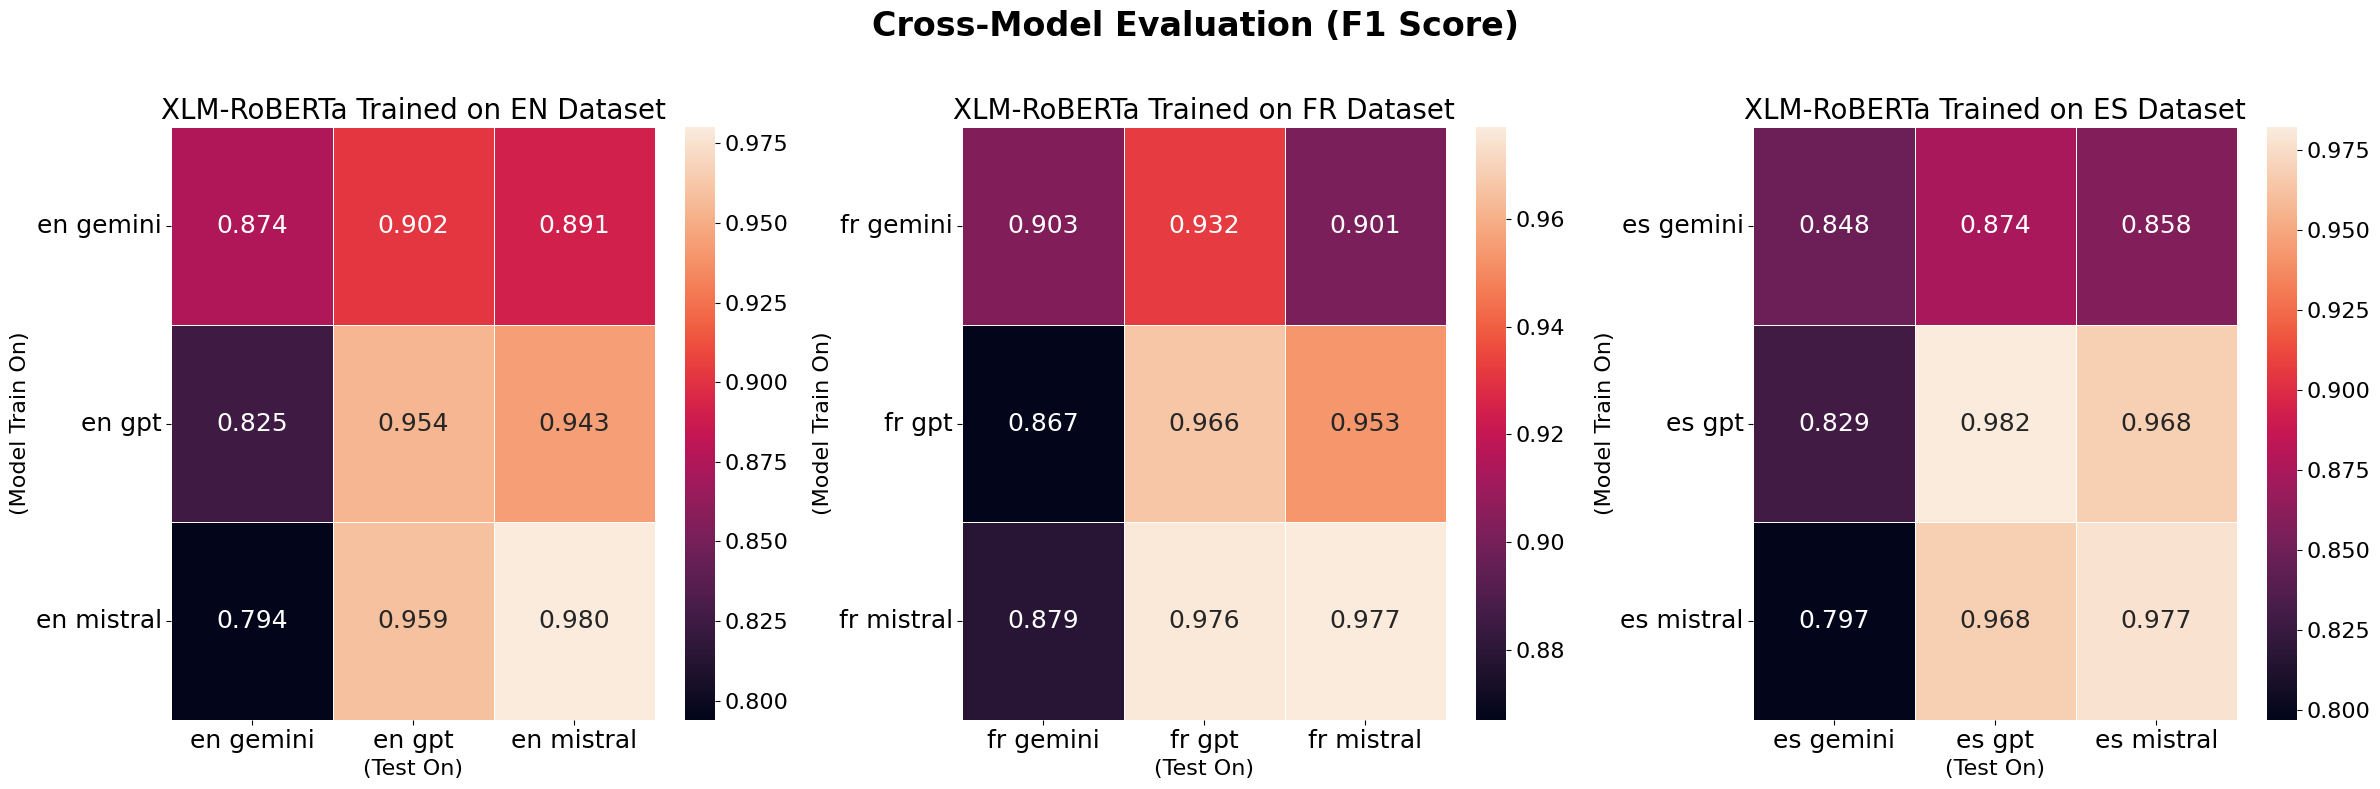

In [42]:
# Load the data from a CSV file
results_df = pd.read_csv('cross_model_evaluation_results.csv')

# Define a list of languages in your dataset
languages = ['en', 'fr', 'es']

# Create a custom color map from white to green
gray_green = LinearSegmentedColormap.from_list("gray_green", ["gray", "green"])


# Apply the function to the 'Model Train On' and 'Test On' column
results_df['Model Train On'] = results_df['Model Train On'].apply(modify_model_name)
results_df['Test On'] = results_df['Test On'].apply(modify_model_and_test_name)

# Create a single figure before the loop
fig = plt.figure(figsize=(24, 8))  # Adjusted size for side-by-side layout

# Add a title to the entire figure
fig.suptitle('Cross-Model Evaluation (F1 Score)', fontsize=24, weight='bold')

# Loop over languages
for i, lang in enumerate(languages):
    # Filter data for the current language
    lang_data = results_df[results_df['Model Train On'].str.contains(lang)]
    heatmap_data = lang_data.pivot(index="Model Train On", columns="Test On", values="F1 Score")

    # Add subplot to the figure created before the loop
    ax = fig.add_subplot(1, len(languages), i + 1)  # Subplot for each language side by side
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", linewidths=.5, 
                annot_kws={"size": 18}, ax=ax)
    ax.set_title(f'XLM-RoBERTa Trained on {lang.upper()} Dataset', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
    ax.set_ylabel('(Model Train On)', fontsize=16)  
    ax.set_xlabel('(Test On)', fontsize=16)

    # Set colorbar properties to increase font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)


plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.savefig('cross_model_evaluation_f1_score.png', dpi=300)
plt.show()

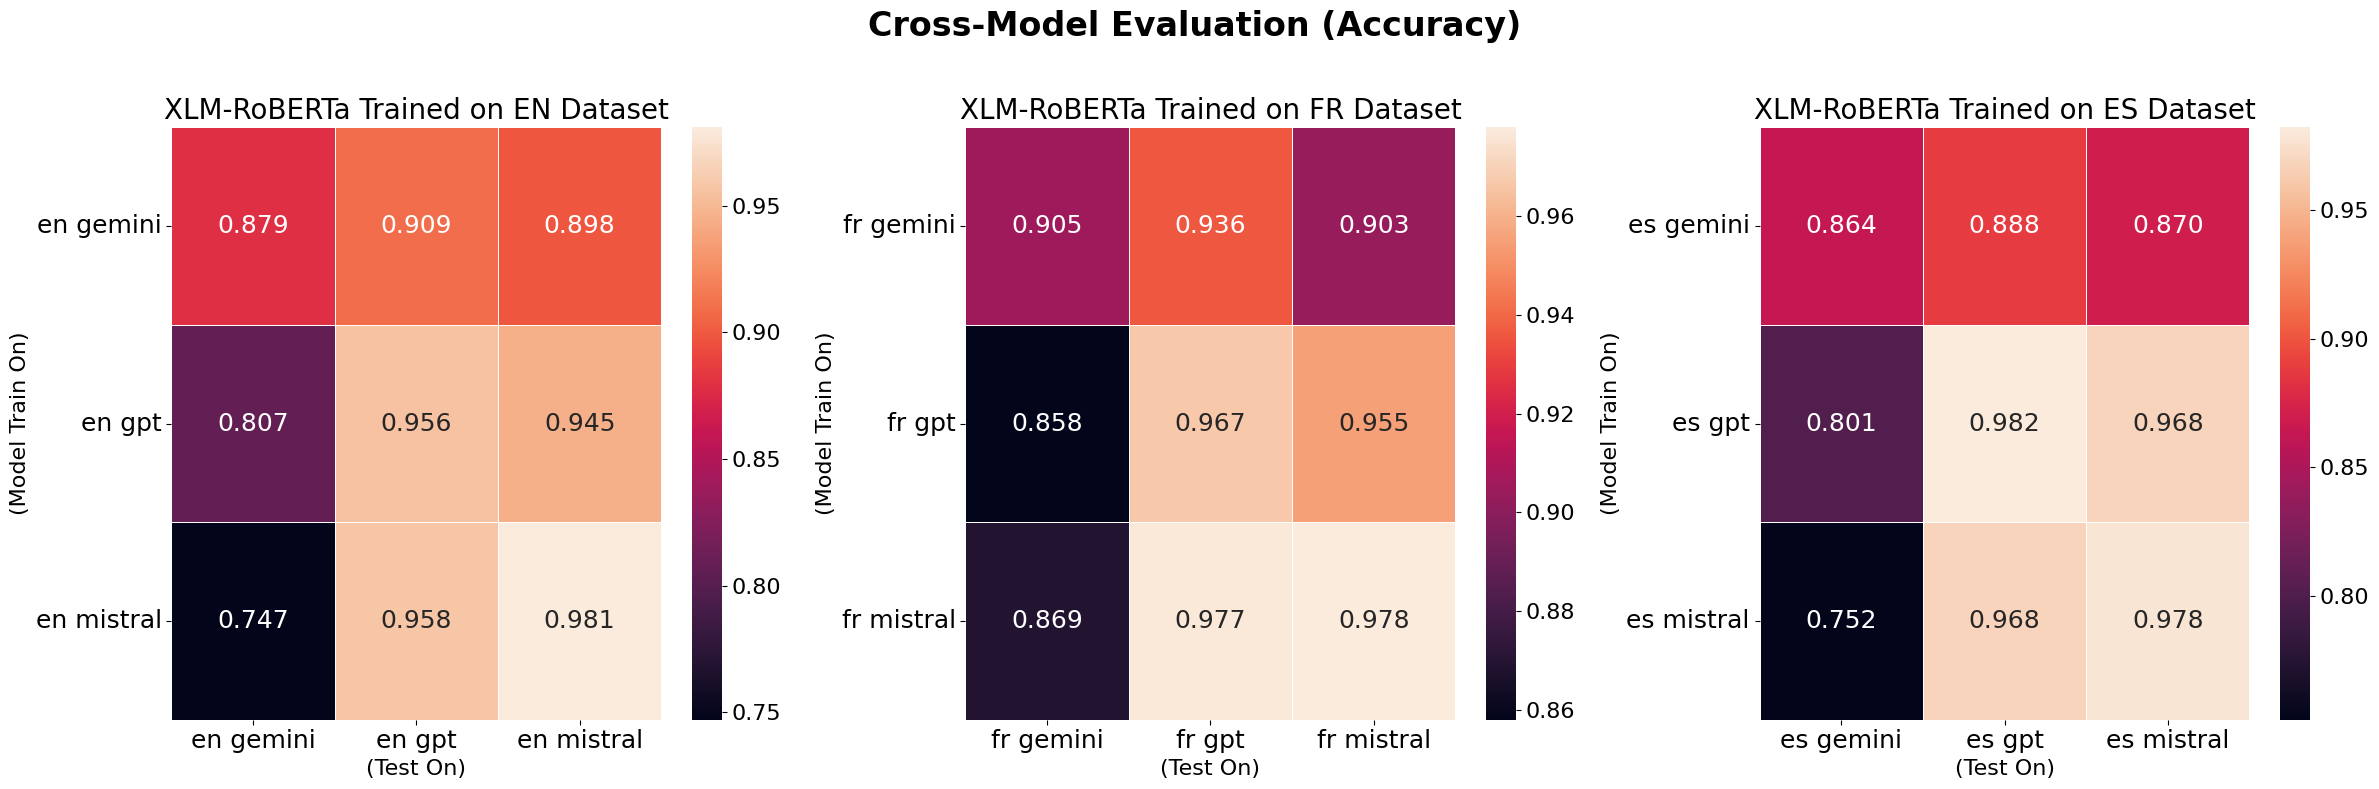

In [43]:
# Load the data from a CSV file
results_df = pd.read_csv('cross_model_evaluation_results.csv')

# Define a list of languages in your dataset
languages = ['en', 'fr', 'es']

# Create a custom color map from white to green
gray_green = LinearSegmentedColormap.from_list("gray_green", ["gray", "green"])


# Apply the function to the 'Model Train On' and 'Test On' column
results_df['Model Train On'] = results_df['Model Train On'].apply(modify_model_name)
results_df['Test On'] = results_df['Test On'].apply(modify_model_and_test_name)

# Create a single figure before the loop
fig = plt.figure(figsize=(24, 8))  # Adjusted size for side-by-side layout

# Add a title to the entire figure
fig.suptitle('Cross-Model Evaluation (Accuracy)', fontsize=24, weight='bold')

# Loop over languages
for i, lang in enumerate(languages):
    # Filter data for the current language
    lang_data = results_df[results_df['Model Train On'].str.contains(lang)]
    heatmap_data = lang_data.pivot(index="Model Train On", columns="Test On", values="Accuracy")

    # Add subplot to the figure created before the loop
    ax = fig.add_subplot(1, len(languages), i + 1)  # Subplot for each language side by side
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", linewidths=.5, 
                annot_kws={"size": 18}, ax=ax)
    ax.set_title(f'XLM-RoBERTa Trained on {lang.upper()} Dataset', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
    ax.set_ylabel('(Model Train On)', fontsize=16)  
    ax.set_xlabel('(Test On)', fontsize=16)

    # Set colorbar properties to increase font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)


plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.savefig('cross_model_evaluation_accuracy.png', dpi=300)
plt.show()

#### This part is just for comparing the evaluation between raw and preprocess datasets.

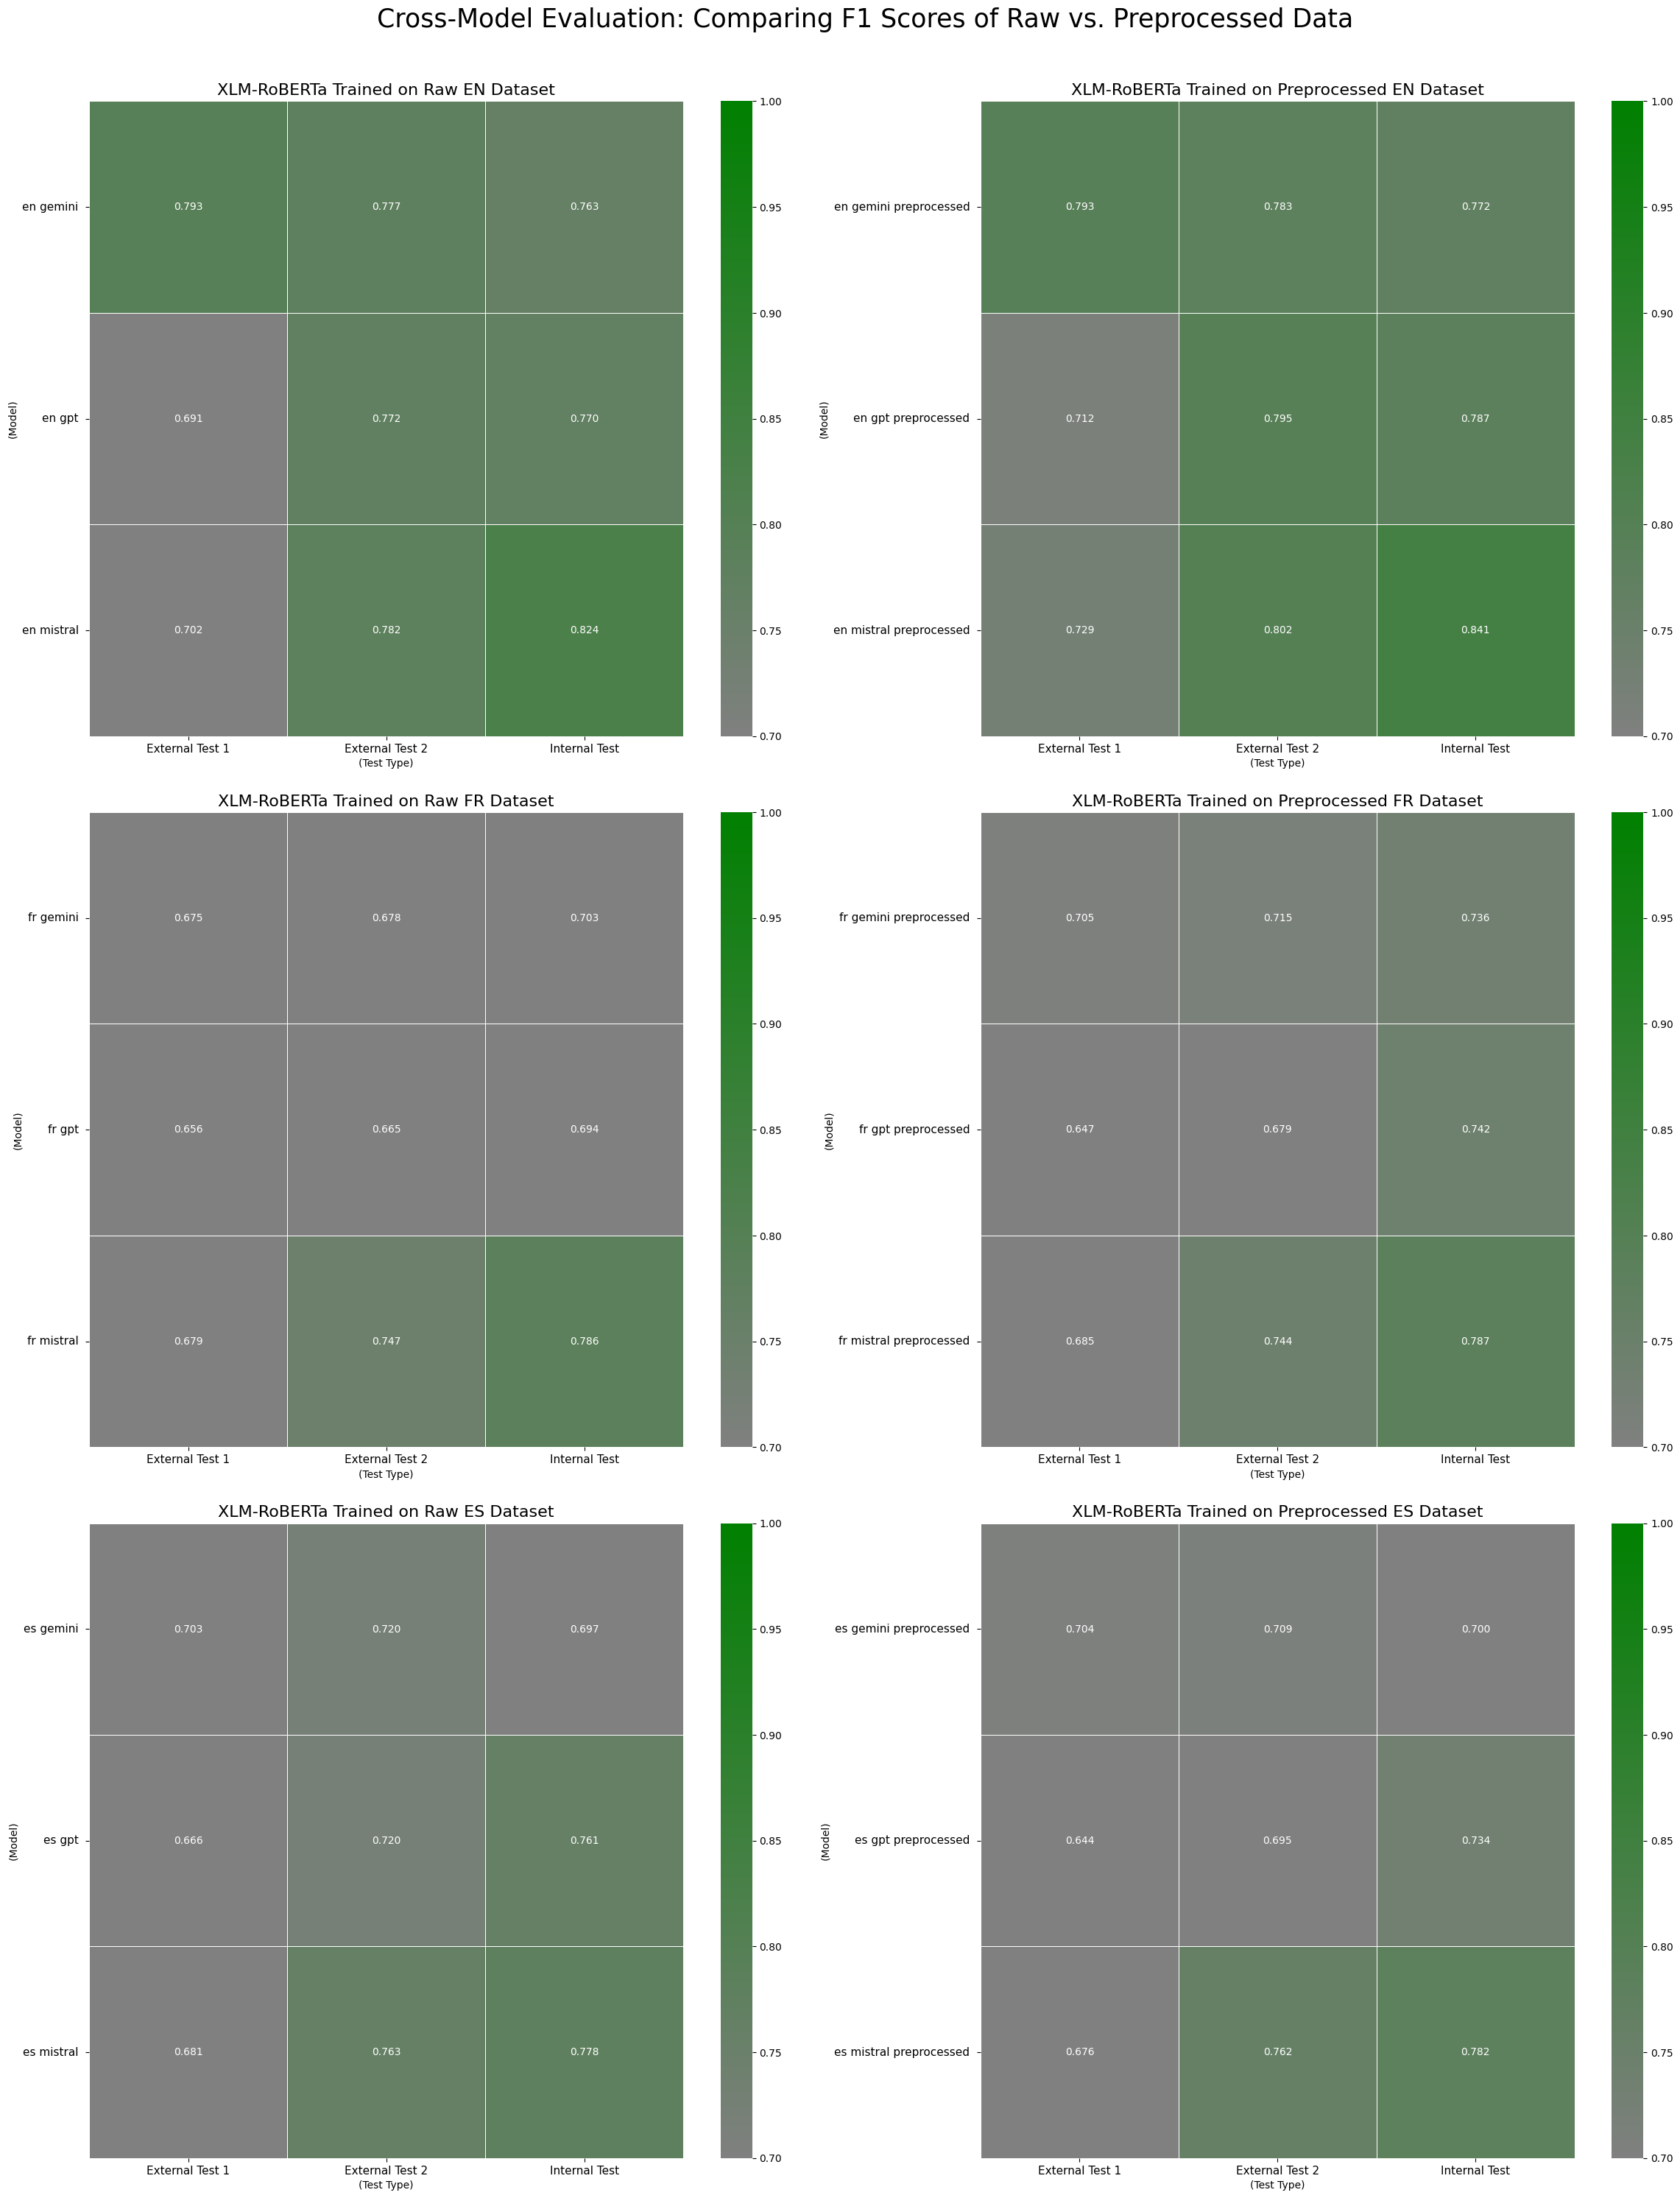

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Load the data from a CSV file
results_df = pd.read_csv('cross_model_evaluation_results_raw_preprocess.csv')

# Define a list of languages in your dataset
languages = ['en', 'fr', 'es']

# Create a custom color map from white to green
gray_green = LinearSegmentedColormap.from_list("gray_green", ["gray", "green"])

# Function to modify model names
def modify_model_name(model_name):
    parts = model_name.split('_')
    new_name = f"{parts[2]} {parts[3]} {'preprocessed ' if 'pre' in parts else ''}"
    return new_name

# Apply the function to the 'Model' column
results_df['Model'] = results_df['Model'].apply(modify_model_name)

# Create a single figure before the loop
fig = plt.figure(figsize=(24, len(languages) * 10))

# Add a title to the entire figure
fig.suptitle('Cross-Model Evaluation: Comparing F1 Scores of Raw vs. Preprocessed Data', fontsize=25, y=1.0)

# Loop over languages
for i, lang in enumerate(languages):
    # Filter data for the current language and for raw data models
    raw_data = results_df[(results_df['Model'].str.contains(f'{lang} ')) & (~results_df['Model'].str.contains('preprocessed'))]
    heatmap_data_raw = raw_data.pivot(index="Model", columns="Test Type", values="F1 Score")
    
    # Filter data for the current language and for preprocessed data models
    preprocessed_data = results_df[(results_df['Model'].str.contains(f'{lang} ')) & (results_df['Model'].str.contains('preprocessed'))]
    heatmap_data_preprocessed = preprocessed_data.pivot(index="Model", columns="Test Type", values="F1 Score")

    # Add subplots to the figure created before the loop
    ax1 = fig.add_subplot(len(languages), 2, 2*i+1)  # First subplot for raw data
    sns.heatmap(heatmap_data_raw, annot=True, fmt=".3f", cmap=gray_green, linewidths=.5, vmin=0.70, vmax=1.0, ax=ax1)
    ax1.set_title(f'XLM-RoBERTa Trained on Raw {lang.upper()} Dataset', fontsize=16)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center', fontsize=11)
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=11)
    ax1.set_ylabel(f'(Model)')  # Add parentheses around the y-axis label
    ax1.set_xlabel(f'(Test Type)')  # Add parentheses around the x-axis label

    ax2 = fig.add_subplot(len(languages), 2, 2*i+2)  # Second subplot for preprocessed data
    sns.heatmap(heatmap_data_preprocessed, annot=True, fmt=".3f", cmap=gray_green, linewidths=.5, vmin=0.70, vmax=1.0, ax=ax2)
    ax2.set_title(f'XLM-RoBERTa Trained on Preprocessed {lang.upper()} Dataset', fontsize=16)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='center', fontsize=11)
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=11)
    ax2.set_ylabel(f'(Model)')  # Add parentheses around the y-axis label
    ax2.set_xlabel(f'(Test Type)')  # Add parentheses around the x-axis label

# Adjust subplots to ensure everything fits without overlap
plt.tight_layout(pad=2.5)  # Increase the padding between subplots


# Save the figure after the loop
plt.savefig('cross_model_evaluation_heatmap_raw_preprocess.png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()

